# Taha Samavati - 98722134 - Pattern Recognition
## **First Project Report**
    Table of contents:
    
    Load and process dataset
    Preprocessing and cleaning comments
    1. Bag of words representation
      1.1. Multinomial Naive Bayes
        1.1.1. Evaluation : Confusion matrix + ROC
      1.2.SVM
        1.2.1 Evaluation : Confusion matrix + ROC
      1.3.Decision Tree
        1.3.1 Evaluation : Confusion matrix + ROC
      1.4.Random Forest
        1.4.1 Evaluation : Confusion matrix + ROC
      1.5. Performance Comparison of classifiers - Bag of words

In [0]:
import numpy as np
import nltk
import re
import pandas as pd
import os
import natsort
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix,roc_curve, auc
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB

# --- Load and Process raw data ---- 
* 1.read dataset files

In [0]:
# list files
train_dir = "./dataset/aclImdb/train/"
test_dir = "./dataset/aclImdb/test/"

train_p = natsort.natsorted(os.listdir(train_dir+"pos"))
train_neg = natsort.natsorted(os.listdir(train_dir+"neg"))

test_p = natsort.natsorted(os.listdir(test_dir+"pos"))
test_neg = natsort.natsorted(os.listdir(test_dir+"neg"))

**2.Create dataframe out of positive and negative comments and use their sentiments as labels**
* the sentiments are part of filename and after underline.
* the sentiment is between 0 to 10.

**In couple of cells later I edit sentiments to make them binary in this way that for sentiments grater than 5 we consider label of 1**
**and for sentiments less than 5 zero is considered.**

In [0]:
def create_dataframe(filenames, directory, positive=True):
    
    df = pd.DataFrame(columns=['comment','sentiment'])
    
    for fname in filenames:
        with open(directory+fname,'r',encoding='utf-8') as comment:
            content = comment.readlines()
            sentiment = fname[-5]
            if positive and fname[-5]=='0': 
                sentiment = '10'
            dict1={'comment':content[0], 'sentiment':sentiment}
            df = df.append(dict1,ignore_index=True)
    return df

# create train and test dataframes
df_train_p = create_dataframe(train_p, train_dir+"pos/")
df_train_n = create_dataframe(train_neg, train_dir+"neg/", False)
df_train = pd.concat([df_train_p,df_train_n],ignore_index=True)

df_test_p = create_dataframe(test_p, test_dir+"pos/")
df_test_n = create_dataframe(test_neg, test_dir+"neg/", False)
df_test = pd.concat([df_test_p,df_test_n],ignore_index=True)

# 0. Preprocessing
 **-Clean each comment**
 * 1.clean html tags and http
 * 2.clean all numbers as they have no semantic meaning
 * 3.replace @ sign with at
 * 4.remove all of punctuation and other signs
 * 5.remove two spaces or more generated after cleaning text
 * 6.lower all characters
 
 **-The procedure is carefully commented in the code below**

In [0]:
def clean_text(df,text_field):
    # clean html tags of <br><br/> and also \/ signs
    df[text_field] = df[text_field].str.replace("(<br\s*/><br\s*/>)|(\-)|(\/)", " ")
    # clean http word cause it has no semantic meaning
    df[text_field] = df[text_field].str.replace(r"http\S+","")
    # clean numbers as they don't have semantic meaning
    df[text_field] = df[text_field].str.replace(r"[1234567890]", "")
    # replace @ sign with at
    df[text_field] = df[text_field].str.replace(r"@", "at ")
    # remove all of punctuation    
    df[text_field] = df[text_field].str.replace("[=.;:!\'?,\"()\[\]]","")
    # finally remove two spaces or more
    df[text_field] = df[text_field].str.replace(r"(\s){2,}", " ")
    # lower all characters
    df[text_field] = df[text_field].str.lower()
    return df

# preprocess and clean text
df_train = clean_text(df_train,"comment")
df_test = clean_text(df_test,"comment")

**Lematization**
 
 replace different word forms of a word with their lemma
 for example convert cats to cat

In [ ]:
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# lemmatization
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

# convert tokenized comments back to strings
def create_string(listin):
  st=""
  for i in range(len(listin)):
    st=st+listin[i]+" "
  return st

# Tokenize then lemmatize and fimally convert tokens back to string
df['comment'] = df.comment.apply(lemmatize_text).apply(create_string)

In [0]:
# Load preprocessed data_frames
df_train = pd.read_csv('/content/gdrive/My Drive/Pattern_Recognition/cleaned_train_df.csv')
df_test = pd.read_csv('/content/gdrive/My Drive/Pattern_Recognition/cleaned_test_df.csv')

# 1. First Method : Bag of Words representation
* Bag of words method builds a matrix from words in a corpus and their frequencies
* each element in that matrix represents a unique word in corpus
* sklearn's CountVectorizer was used to convert each comment to a bag of words representation
* due to large consumption of memmory and time when training with full sized BoW vector, the max features parameter was set to lower value : 16000
* **The 'max_features' hyper parameter removes words that have relatively low frequencies from BoW vector so the sparcity of the matrix and it's dimension is reduced significantly.**
* **why 16000 ? this value selected emperically to deliver best performance and accracy. some more sophisticated way is to analyze word frequencies and remove words that happened less than a threshold value say 5 or 10.**
* the limited features work well with different classifiers.

In [0]:
# BoW representation
max_features = 16000
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features=max_features) 
train_data_features = vectorizer.fit_transform(df_train.comment)

* **Vectorize comments (Bag of Words) to be able to feed them to algorithms**

In [ ]:
# Create vectorized train and test set
X_train = np.zeros((25000,max_features),dtype=np.int16)
for i in range(df_train.shape[0]):
    X_train[i] = vectorizer.transform([df_train.loc[i]['comment']]).toarray()[0]

X_test = np.zeros((25000,max_features),dtype=np.int16)
for i in range(df_test.shape[0]):
    X_test[i] = vectorizer.transform([df_test.loc[i]['comment']]).toarray()[0]

y_train = df_train.sentiment.astype('uint8')
y_test = df_test.sentiment.astype('uint8')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

* **Make Labels binary** 

* sentiment > 5 --> '1'

* sentiment < 5 --> '0'

In [0]:
# convert 0-10 sentiments to binary sentiments
for i in range(y_train.shape[0]):
    if (y_train.iloc[i]>5):
        y_train.iloc[i] = 1
    else :
        y_train.iloc[i] = 0

for i in range(y_test.shape[0]):
    if (y_test.iloc[i]>5):
        y_test.iloc[i] = 1
    else :
        y_test.iloc[i] = 0

## 1.1 Multinomial Naive Bayes

* Naive Bayes classifiers are a collection of classification algorithms based on Bayes’ Theorem.
* The fundamental Naive Bayes assumption is that each feature makes an: 1.independent 2.equal contribution to output
* Bayes Theorem 
image.png
* with naive assumptions bayes theorem becomes :
image.png
* so we need to know each feature's probability distribution
* As we often don't know probability distributions for each feature when input data features are very high dimensional and we can't compute them we make some assumptions
* for example we assume that the probability distribution of each feature is gaussian
* But for this part of project as we have frequencies of words as features and they're discrete, the Multinomial Naive bayes performs better
* Gaussian NB is for continous data
* According to sklean's website:
* The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts
* For class j, word i at a word frequency of f:
* P(j|i) = p(j) * P(i1|j)^f1* P(i2|j)^f2* P(i3|j)^f3 ...

In [0]:
from sklearn.naive_bayes import MultinomialNB
# Create and fit Multinomial Naive Bayes classifier
mnb = MultinomialNB()
bnb_model = mnb.fit(X_train,y_train)

### 1.1.1 EVALUATION

In [10]:
# Predict and print metrics
y_pred_mnb = np.zeros((X_test.shape[0]),dtype=np.int8)
for i in range(X_test.shape[0]):
    y_pred_mnb[i] = mnb.predict([X_test[i]])
#y_pred = gnb.predict(X_test)
precision,recall,fscore,_ = precision_recall_fscore_support(y_test, y_pred_mnb, average='weighted')
print("Presicion = "+str(precision*100)+" % Recall = "+str(recall*100)+" % f1 = "+str(fscore*100)+" %")
# store precision
precisions=[]
precisions.append(precision)

Presicion = 82.40687695776377 % Recall = 82.04 % f1 = 81.9890246170321 %


In [0]:
def plot_confusion_matrix(y_true,y_predicted, classes, normalize=False, title=None, cmap = plt.cm.Blues):
    if not title:
        if normalize:
            title = "Normalized Confusion matrix"
        else:
            title = "Confusion matrix, Without normalization"
    cm = confusion_matrix(y_true, y_predicted)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis = 1)[:,np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation = 'nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),yticks=np.arange(cm.shape[0]),xticklabels=classes, yticklabels=classes,
          title=title,
          ylabel='True label',
          xlabel="predicted label")
    plt.setp(ax.get_xticklabels(), rotation=45,ha='right', rotation_mode='anchor')
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

* The confusion matrix can be very useful for evaluating classifier's performance
* The elemnts on the Main diagonal show the True positive rate and true nagative counts
* The Off-diagonal elements show false positive and false negative counts
* The overall true predictions are 20855 and false predictions are 4145

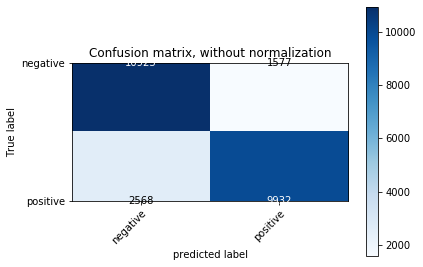

In [0]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_brnl, classes=['negative','positive'],
                      title='Confusion matrix, without normalization')

plt.show()

## ROC Curve
* Another preformance measure for classifiers is ROC and AUC
* ROC is a curve that shows True positive rate versus False Positive rate
* When the True positive rate is increased model can better detect positive samples but the cost is that the false positive rate is also increased
* AUC is the area under ROC and shows how well the model can distinguish between negative and positive classes.
* According to wikipedia:
* The area under the curve (or AUC) is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one (assuming 'positive' ranks higher than 'negative').
* The bigger AUC, The better is the classifier.
* AUC is specified in figure and is 83.42

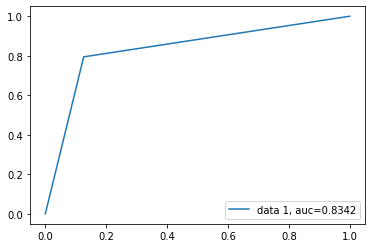

In [0]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_brnl)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr,tpr,label="data 1, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

## 1.2. SVM Classifier
* fit an SVM to BoW data
* Linear SVM finds best hyperplane to find best decision boundary by maximizing margin
* The linear kernel is K(xi, xj) = x′i * xj.
* The Linear svm maps input to a feature space where it can be linearly separated (does not work for all types of input)
* It has one hyper paramete C.
* Small C makes the constraints easy to ignore which leads to a large margin.
* Large C allows the constraints hard to be ignored which leads to a small margin.
* The value of C here choosed emperically (not very large and not very small)
* In practical applications best C is often choosed with GridSearch

In [11]:
svmc = LinearSVC(C=0.01)
svmc.fit(X_train,y_train)

LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### 1.2.1. Evaluation

In [12]:
# Predict and print metrics
y_pred_svm = np.zeros((X_test.shape[0]),dtype=np.int8)
for i in range(X_test.shape[0]):
    y_pred_svm[i] = svmc.predict([X_test[i]])
#y_pred = gnb.predict(X_test)
precision,recall,fscore,_ = precision_recall_fscore_support(y_test, y_pred_svm, average='weighted')
print("Presicion = "+str(precision*100)+" % Recall = "+str(recall*100)+" % f1 = "+str(fscore*100)+" %")
precisions.append(precision)

Presicion = 87.63689630010325 % Recall = 87.636 % f1 = 87.63592638925134 %


### Confusion Matrix

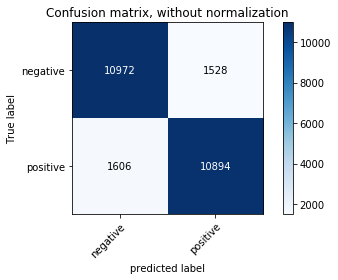

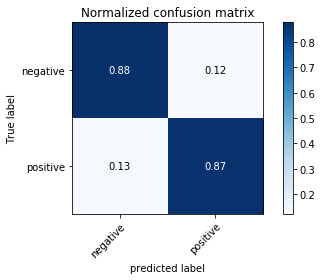

In [0]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_svm, classes=['negative','positive'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_svm, classes=['negative','positive'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## ROC Curve
Auc = 87.46

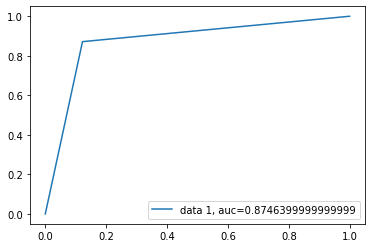

In [0]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_svm)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr,tpr,label="data 1, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

## 1.3. Decision Tree Classifier

* Finds the optimum tree by selecting features that have the most pureness first
* the impurity measure used in here is gini
* decision Tree CART trainnig algorithm finds the features that have the minimum impurity using gini measure and splits the tree by that features first
* the random_state parameter is specified to generate same random numbers to be able to get same results after executing the code again
* there are some hyperparameters that weren't used here
* such as max_depth that limits the tree depth ==> can some times reduce overfitting
* or the max_leaf_nodes which limits the number of the decision tree's leaf nodes to a number
* or the mean_impurity_split that specifies minimum impurity of a node to split required to split the node which can again reduce overfitting and improve generalization when choosed appropirately.

In [13]:
# Fit DT classifier
dtc = DTC(random_state=76)
dtc.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=76, splitter='best')

### 1.3.1. Evaluation

In [14]:
# Predict and print metrics
y_pred_dtc = np.zeros((X_test.shape[0]),dtype=np.int8)
for i in range(X_test.shape[0]):
    y_pred_dtc[i] = dtc.predict([X_test[i]])

precision,recall,fscore,_ = precision_recall_fscore_support(y_test, y_pred_dtc, average='weighted')
print("Presicion = "+str(precision*100)+" % Recall = "+str(recall*100)+" % f1 = "+str(fscore*100)+" %")
precisions.append(precision)

Presicion = 71.55600124162567 % Recall = 71.556 % f1 = 71.5559995904064 %


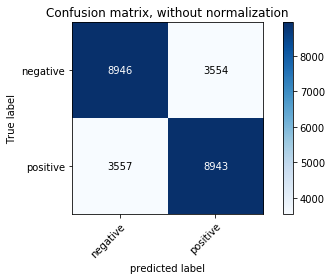

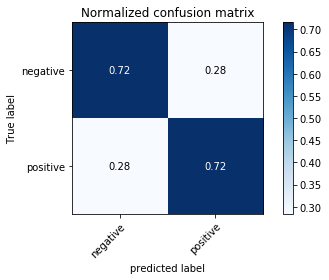

In [0]:
# Plot Confusion Matrix

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_dtc, classes=['negative','positive'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_dtc, classes=['negative','positive'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

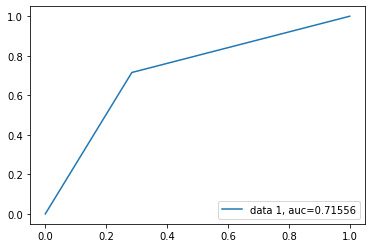

In [0]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_dtc)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr,tpr,label="data 1, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

## 1.4 Random Forest classifier

* A random forest is an estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the prediction accuracy and control over-fitting.

* here I used 24 estimators(DTs)
* the hyper_parameters are almost like Decesion tree such as max depth and min_impurity_split,...

In [15]:
rfc = RandomForestClassifier(n_estimators=24, random_state=42)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=24,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### 1.4.1. Evaluation

In [16]:
# Predict and print metrics
y_pred_rfc = np.zeros((X_test.shape[0]),dtype=np.int8)
for i in range(X_test.shape[0]):
    y_pred_rfc[i] = rfc.predict([X_test[i]])

precision,recall,fscore,_ = precision_recall_fscore_support(y_test, y_pred_rfc, average='weighted')
print("Presicion = "+str(precision*100)+" % Recall = "+str(recall*100)+" % f1 = "+str(fscore*100)+" %")
precisions.append(precision)

Presicion = 80.58927801281524 % Recall = 80.50399999999999 % f1 = 80.49040259098982 %


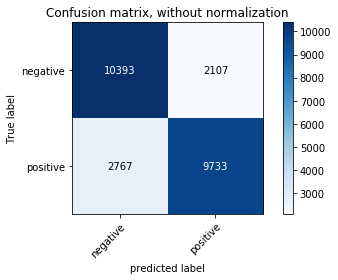

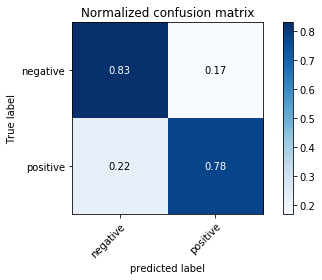

In [0]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_rfc, classes=['negative','positive'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_rfc, classes=['negative','positive'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

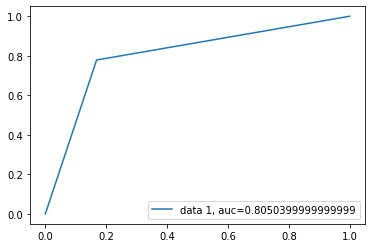

In [0]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_rfc)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr,tpr,label="data 1, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

# 1.5 Comparison  - BoW method

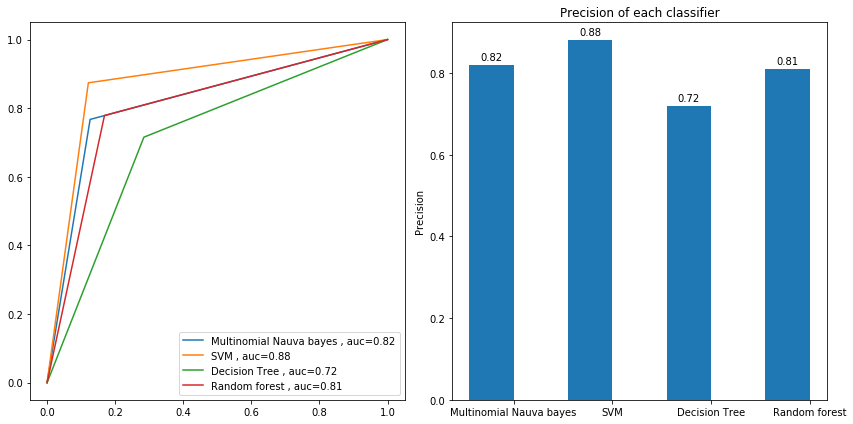

In [0]:
def autolabel(rects):
    """Attach a text label above each bar """
    for rect in rects:
        height = rect.get_height()
        ax[1].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Compare ROC and AUC among different classifiers
y_preds = [y_pred_mnb, y_pred_svm, y_pred_dtc, y_pred_rfc]
clsf_names=['Multinomial Nauva bayes','SVM','Decision Tree','Random forest']
#plt.figure()
fig, ax = plt.subplots(1,2,figsize=(12,6))
for i in range(len(y_preds)):

  fpr, tpr, _ = roc_curve(y_test, y_preds[i])
  roc_auc = auc(fpr, tpr)
  ax[0].plot(fpr,tpr,label=clsf_names[i]+" , auc="+str(round(roc_auc,2)))
  
ax[0].legend(loc=4)
#plt.show()
 
labels = clsf_names
data = np.round(precisions,2)

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars


rects1 = ax[1].bar(x - width/2, data, width, label="Prec")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision of each classifier')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
#ax.legend()

autolabel(rects1)

fig.tight_layout()

plt.show()


* From figures above the SVM is the best classifier for BoW method with highest precision and AUC
* The more the Auc, The better the classifier can distinguish between negative and positive classes
* SVM has the best ROC curve (the nearest to ideal ROC which is a step function from 0 to 1)